In [92]:
import gym
import tensorflow as tf
import numpy as np
import statistics
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Flatten, Dense
import collections
import tqdm
import matplotlib.pyplot as plt

env = gym.make("ALE/IceHockey-v5", obs_type="rgb")

seed = 21
tf.random.set_seed(seed)
np.random.seed(seed)

eps = np.finfo(np.float32).eps.item()

In [93]:
# class ActorCritic(Model):
#   def __init__(
#       self,
#       num_actions: int,
#       num_hidden_units: int):
#     super().__init__()

#     self.common = layers.Dense(num_hidden_units, activation="relu")
#     self.actor = layers.Dense(num_actions)
#     self.critic = layers.Dense(1)

#   def call(self, inputs: tf.Tensor):
#     x = self.common(inputs)
#     return self.actor(x), self.critic(x)

In [94]:
from tensorflow import keras

class ActorCritic(Model):
  def __init__(self, num_actions: int, num_hidden_units: int):
    super().__init__()

    # self.common = layers.Dense(num_hidden_units, activation="relu")
    self.conv0 = keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', input_shape=[210, 160, 3])
    # Convolutional layers for feature extraction
    self.conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu')
    self.pool1 = keras.layers.MaxPooling2D((2, 2))
    self.conv2 = keras.layers.Conv2D(64, (4, 4), activation='relu')
    self.pool2 = keras.layers.MaxPooling2D((2, 2))
    self.conv3 = keras.layers.Conv2D(32, (5, 5), activation='relu')
    self.pool3 = keras.layers.MaxPooling2D((2, 2))
    self.conv4 = keras.layers.Conv2D(32, (5, 5), activation='relu')

    # Flatten the output from the convolutional layers
    self.flatten = keras.layers.Flatten()

    # Hidden layer with ReLU activation
    self.common = keras.layers.Dense(num_hidden_units, activation="relu")

    # Actor branch for policy
    self.actor = keras.layers.Dense(num_actions, activation='softmax')

    # Critic branch for state value estimation
    self.critic = keras.layers.Dense(1)

  def call(self, inputs: tf.Tensor):
    # x = self.common(inputs)
    x = self.conv0(inputs)
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.pool3(x)
    x = self.conv4(x)
    x = self.flatten(x)
    x = self.common(x)
    return self.actor(x), self.critic(x)

In [95]:
# import tensorflow as tf

# class ActorCritic(Model):
#   def __init__(self, num_actions: int,num_hidden_units: int):
#     super().__init__()

#     # Define the convolutional layers
#     self.conv1 = tf.keras.layers.Conv2D(
#         filters=64, kernel_size=3, activation="relu")
#     self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
#     self.conv2 = tf.keras.layers.Conv2D(
#         filters=64, kernel_size=4, activation="relu")
#     self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
#     self.conv3 = tf.keras.layers.Conv2D(
#         filters=32, kernel_size=5, activation="relu")
#     self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
#     self.conv4 = tf.keras.layers.Conv2D(
#         filters=32, kernel_size=5, activation="relu")
#     self.flatten = tf.keras.layers.Flatten()

#     # Define the hidden layer
#     self.fc1 = tf.keras.layers.Dense(units=num_hidden_units, activation="relu")

#     # Define the actor and critic outputs
#     self.actor = tf.keras.layers.Dense(num_actions, activation="softmax")
#     self.critic = tf.keras.layers.Dense(1)

#   def call(self, inputs):
#     x = self.conv1(inputs)
#     x = self.pool1(x)
#     x = self.conv2(x)
#     x = self.pool2(x)
#     x = self.conv3(x)
#     x = self.pool3(x)
#     x = self.conv4(x)
#     x = self.flatten(x)
#     x = self.fc1(x)
#     actor_output = self.actor(x)
#     critic_output = self.critic(x)

#     return actor_output, critic_output

In [96]:
num_actions = env.action_space.n
num_hidden_units = 512

model = ActorCritic(num_actions, num_hidden_units)

In [97]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [98]:
@tf.numpy_function(Tout=[tf.float32, tf.int32, tf.int32])
def env_step(action: np.ndarray):
  """Returns state, reward and done flag given an action."""

  state, reward, done, truncated, info = env.step(action)
  return (state.astype(np.float32),
          np.array(reward, np.int32),
          np.array(done, np.int32))

In [99]:
def run_episode(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    max_steps: int):
    """Runs a single episode to collect training data."""
    
    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
    
    initial_state_shape = initial_state.shape
    state = initial_state
    
    for t in tf.range(max_steps):
        # Convert state into a batched tensor (batch size = 1)
        state = tf.expand_dims(state, 0)
        
        # Run the model and to get action probabilities and critic value
        action_logits_t, value = model(state)
        #action_logits_t = tf.squeeze(action_logits_t)
        # Sample next action from the action probability distribution
        action = tf.random.categorical(action_logits_t, 1)[0, 0]
        action_probs_t = tf.nn.softmax(action_logits_t)
        
        # Store critic values
        values = values.write(t, tf.squeeze(value))
        
        # Store log probability of the action chosen
        action_probs = action_probs.write(t, action_probs_t[0, action])
        
        # Apply action to the environment to get next state and reward
        state, reward, done = env_step(action)
        state.set_shape(initial_state_shape)
        
        # Store reward
        rewards = rewards.write(t, reward)
        
        if tf.cast(done, tf.bool):
          break
    
    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()
    
    return action_probs, values, rewards

In [100]:
def get_expected_return(
    rewards: tf.Tensor,
    gamma: float,
    standardize: bool = True):
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) /
               (tf.math.reduce_std(returns) + eps))

  return returns

In [101]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,
    values: tf.Tensor,
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined Actor-Critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

In [102]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    optimizer: tf.keras.optimizers.Optimizer,
    gamma: float,
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode)

    # Calculate the expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]]

    # Calculate the loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward
  #return episode_reward if episode_reward is not None else -3

In [105]:
%%time

min_episodes_criterion = 50
max_episodes = 1000
max_steps_per_episode = 100

reward_threshold = 0
running_reward = 0

# The discount factor for future rewards
gamma = 0.99

# Keep the last episodes reward
episodes_reward = []

t = tqdm.trange(max_episodes)
with tf.device('/GPU:0'):
    for i in t:
        initial_state, info = env.reset()
        initial_state = tf.constant(initial_state, dtype=tf.float32)
        # initial_state = tf.squeeze(initial_state)
        # initial_state = initial_state[:, :]
        # initial_state = tf.expand_dims(initial_state, axis=0)
        episode_reward = int(train_step(
            initial_state, model, optimizer, gamma, max_steps_per_episode))

        episodes_reward.append(episode_reward)
        running_reward = statistics.mean(episodes_reward)

        t.set_postfix(
            episode_reward=episode_reward, running_reward=running_reward)

        # Show the average episode reward every 10 episodesa
        if i % 10 == 0:
            print(f'Episode {i}: average reward: {running_reward}')
            pass # 

        #ice hockey doesn't have a reward threshold as there is no score limit
        if running_reward > reward_threshold and i >= min_episodes_criterion:
           break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|          | 0/1000 [00:00<?, ?it/s]2024-05-08 17:04:41.996671: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fabe4abf0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 17:04:41.996723: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-08 17:04:42.010976: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715184282.093969   20660 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
  0%|          | 1/1000 [00:04<1:21:07,  4.87s/it, episode_reward=0, running_reward=0]

Episode 0: average reward: 0


  1%|          | 11/1000 [00:11<12:00,  1.37it/s, episode_reward=0, running_reward=0.0909]

Episode 10: average reward: 0.09090909090909091


  2%|▏         | 21/1000 [00:18<10:55,  1.49it/s, episode_reward=-1, running_reward=-0.0476]

Episode 20: average reward: -0.047619047619047616


  3%|▎         | 31/1000 [00:25<10:51,  1.49it/s, episode_reward=-1, running_reward=-0.0645]

Episode 30: average reward: -0.06451612903225806


  4%|▍         | 41/1000 [00:31<10:21,  1.54it/s, episode_reward=0, running_reward=-0.0488] 

Episode 40: average reward: -0.04878048780487805


  5%|▌         | 51/1000 [00:38<10:22,  1.52it/s, episode_reward=0, running_reward=-0.0392]

Episode 50: average reward: -0.0392156862745098


  6%|▌         | 61/1000 [00:44<10:26,  1.50it/s, episode_reward=0, running_reward=-0.0328]

Episode 60: average reward: -0.03278688524590164


  7%|▋         | 71/1000 [00:51<10:09,  1.52it/s, episode_reward=0, running_reward=-0.0282]

Episode 70: average reward: -0.028169014084507043


  8%|▊         | 81/1000 [00:58<10:09,  1.51it/s, episode_reward=0, running_reward=-0.0247]

Episode 80: average reward: -0.024691358024691357


  9%|▉         | 91/1000 [01:04<09:52,  1.53it/s, episode_reward=0, running_reward=-0.022] 

Episode 90: average reward: -0.02197802197802198


 10%|█         | 101/1000 [01:11<10:15,  1.46it/s, episode_reward=0, running_reward=-0.0198]

Episode 100: average reward: -0.019801980198019802


 11%|█         | 111/1000 [01:17<09:41,  1.53it/s, episode_reward=0, running_reward=-0.018] 

Episode 110: average reward: -0.018018018018018018


 12%|█▏        | 121/1000 [01:24<09:38,  1.52it/s, episode_reward=0, running_reward=-0.0165]

Episode 120: average reward: -0.01652892561983471


 13%|█▎        | 131/1000 [01:30<09:17,  1.56it/s, episode_reward=0, running_reward=-0.0153]

Episode 130: average reward: -0.015267175572519083


 14%|█▍        | 141/1000 [01:37<08:59,  1.59it/s, episode_reward=0, running_reward=-0.0142]

Episode 140: average reward: -0.014184397163120567


 15%|█▌        | 151/1000 [01:44<09:24,  1.50it/s, episode_reward=0, running_reward=-0.0132]

Episode 150: average reward: -0.013245033112582781


 16%|█▌        | 161/1000 [01:50<09:46,  1.43it/s, episode_reward=0, running_reward=-0.0124]

Episode 160: average reward: -0.012422360248447204


 17%|█▋        | 171/1000 [01:56<08:01,  1.72it/s, episode_reward=0, running_reward=-0.0117]

Episode 170: average reward: -0.011695906432748537


 18%|█▊        | 181/1000 [02:03<08:53,  1.54it/s, episode_reward=0, running_reward=-0.011] 

Episode 180: average reward: -0.011049723756906077


 19%|█▉        | 191/1000 [02:09<07:32,  1.79it/s, episode_reward=0, running_reward=-0.0105]

Episode 190: average reward: -0.010471204188481676


 20%|██        | 201/1000 [02:15<09:12,  1.45it/s, episode_reward=0, running_reward=-0.00995]

Episode 200: average reward: -0.009950248756218905


 21%|██        | 211/1000 [02:22<08:17,  1.59it/s, episode_reward=0, running_reward=-0.00948]

Episode 210: average reward: -0.009478672985781991


 22%|██▏       | 221/1000 [02:28<08:18,  1.56it/s, episode_reward=0, running_reward=-0.00905]

Episode 220: average reward: -0.00904977375565611


 23%|██▎       | 231/1000 [02:35<08:40,  1.48it/s, episode_reward=0, running_reward=-0.00866]

Episode 230: average reward: -0.008658008658008658


 24%|██▍       | 241/1000 [02:41<08:23,  1.51it/s, episode_reward=0, running_reward=-0.0083] 

Episode 240: average reward: -0.008298755186721992


 25%|██▌       | 251/1000 [02:48<08:18,  1.50it/s, episode_reward=0, running_reward=-0.00797]

Episode 250: average reward: -0.00796812749003984


 26%|██▌       | 261/1000 [02:55<08:04,  1.53it/s, episode_reward=0, running_reward=-0.00766]

Episode 260: average reward: -0.007662835249042145


 27%|██▋       | 271/1000 [03:01<08:05,  1.50it/s, episode_reward=0, running_reward=-0.00738]

Episode 270: average reward: -0.007380073800738007


 28%|██▊       | 281/1000 [03:08<08:12,  1.46it/s, episode_reward=0, running_reward=-0.00712]

Episode 280: average reward: -0.0071174377224199285


 29%|██▉       | 291/1000 [03:15<08:54,  1.33it/s, episode_reward=0, running_reward=-0.00687]

Episode 290: average reward: -0.006872852233676976


 30%|███       | 301/1000 [03:22<07:46,  1.50it/s, episode_reward=0, running_reward=-0.00664]

Episode 300: average reward: -0.006644518272425249


 31%|███       | 311/1000 [03:29<07:30,  1.53it/s, episode_reward=0, running_reward=-0.00643]

Episode 310: average reward: -0.006430868167202572


 32%|███▏      | 321/1000 [03:36<07:40,  1.48it/s, episode_reward=0, running_reward=-0.00623]

Episode 320: average reward: -0.006230529595015576


 33%|███▎      | 331/1000 [03:42<07:51,  1.42it/s, episode_reward=0, running_reward=-0.00604]

Episode 330: average reward: -0.006042296072507553


 34%|███▍      | 341/1000 [03:50<08:05,  1.36it/s, episode_reward=0, running_reward=-0.00587]

Episode 340: average reward: -0.005865102639296188


 35%|███▌      | 351/1000 [03:56<07:14,  1.49it/s, episode_reward=0, running_reward=-0.0057] 

Episode 350: average reward: -0.005698005698005698


 36%|███▌      | 361/1000 [04:03<06:56,  1.53it/s, episode_reward=0, running_reward=-0.00554]

Episode 360: average reward: -0.00554016620498615


 37%|███▋      | 371/1000 [04:09<07:05,  1.48it/s, episode_reward=0, running_reward=-0.00539]

Episode 370: average reward: -0.005390835579514825


 38%|███▊      | 381/1000 [04:16<07:04,  1.46it/s, episode_reward=0, running_reward=-0.00525]

Episode 380: average reward: -0.005249343832020997


 39%|███▉      | 391/1000 [04:23<06:50,  1.48it/s, episode_reward=0, running_reward=-0.00512]

Episode 390: average reward: -0.005115089514066497


 40%|████      | 401/1000 [04:30<06:34,  1.52it/s, episode_reward=0, running_reward=-0.00499]

Episode 400: average reward: -0.004987531172069825


 41%|████      | 411/1000 [04:36<06:30,  1.51it/s, episode_reward=0, running_reward=-0.00487]

Episode 410: average reward: -0.004866180048661801


 42%|████▏     | 421/1000 [04:43<06:23,  1.51it/s, episode_reward=0, running_reward=-0.00475]

Episode 420: average reward: -0.004750593824228029


 43%|████▎     | 431/1000 [04:49<05:46,  1.64it/s, episode_reward=0, running_reward=-0.00464]

Episode 430: average reward: -0.004640371229698376


 44%|████▍     | 441/1000 [04:55<05:19,  1.75it/s, episode_reward=0, running_reward=-0.00454]

Episode 440: average reward: -0.0045351473922902496


 45%|████▌     | 451/1000 [05:01<05:20,  1.71it/s, episode_reward=0, running_reward=-0.00443]

Episode 450: average reward: -0.004434589800443459


 46%|████▌     | 461/1000 [05:07<05:14,  1.72it/s, episode_reward=0, running_reward=-0.00434]

Episode 460: average reward: -0.004338394793926247


 47%|████▋     | 471/1000 [05:12<05:12,  1.69it/s, episode_reward=0, running_reward=-0.00425]

Episode 470: average reward: -0.004246284501061571


 48%|████▊     | 481/1000 [05:18<05:00,  1.73it/s, episode_reward=0, running_reward=-0.00416]

Episode 480: average reward: -0.004158004158004158


 49%|████▉     | 491/1000 [05:24<04:55,  1.72it/s, episode_reward=0, running_reward=-0.00407]

Episode 490: average reward: -0.004073319755600814


 50%|█████     | 501/1000 [05:30<04:48,  1.73it/s, episode_reward=0, running_reward=-0.00399]

Episode 500: average reward: -0.003992015968063872


 51%|█████     | 511/1000 [05:36<04:52,  1.67it/s, episode_reward=0, running_reward=-0.00391]

Episode 510: average reward: -0.003913894324853229


 52%|█████▏    | 521/1000 [05:42<04:42,  1.70it/s, episode_reward=0, running_reward=-0.00384]

Episode 520: average reward: -0.003838771593090211


 53%|█████▎    | 531/1000 [05:48<04:39,  1.68it/s, episode_reward=0, running_reward=-0.00377]

Episode 530: average reward: -0.003766478342749529


 54%|█████▍    | 541/1000 [05:54<04:30,  1.70it/s, episode_reward=0, running_reward=-0.0037] 

Episode 540: average reward: -0.0036968576709796672


 55%|█████▌    | 551/1000 [06:00<04:18,  1.73it/s, episode_reward=0, running_reward=-0.00363]

Episode 550: average reward: -0.003629764065335753


 56%|█████▌    | 561/1000 [06:05<04:01,  1.82it/s, episode_reward=0, running_reward=-0.00357]

Episode 560: average reward: -0.0035650623885918


 57%|█████▋    | 571/1000 [06:11<03:58,  1.80it/s, episode_reward=0, running_reward=-0.0035] 

Episode 570: average reward: -0.0035026269702276708


 58%|█████▊    | 581/1000 [06:16<03:56,  1.77it/s, episode_reward=0, running_reward=-0.00344]

Episode 580: average reward: -0.0034423407917383822


 59%|█████▉    | 591/1000 [06:22<03:44,  1.82it/s, episode_reward=0, running_reward=-0.00338]

Episode 590: average reward: -0.00338409475465313


 60%|██████    | 601/1000 [06:28<03:41,  1.80it/s, episode_reward=0, running_reward=-0.00333]

Episode 600: average reward: -0.0033277870216306157


 61%|██████    | 611/1000 [06:33<03:44,  1.73it/s, episode_reward=0, running_reward=-0.00327]

Episode 610: average reward: -0.0032733224222585926


 62%|██████▏   | 621/1000 [06:39<03:38,  1.73it/s, episode_reward=0, running_reward=-0.00322]

Episode 620: average reward: -0.00322061191626409


 63%|██████▎   | 631/1000 [06:45<03:29,  1.76it/s, episode_reward=0, running_reward=-0.00317]

Episode 630: average reward: -0.003169572107765452


 64%|██████▍   | 641/1000 [06:50<03:22,  1.77it/s, episode_reward=0, running_reward=-0.00312]

Episode 640: average reward: -0.0031201248049922


 65%|██████▌   | 651/1000 [06:56<03:18,  1.76it/s, episode_reward=0, running_reward=-0.00307]

Episode 650: average reward: -0.0030721966205837174


 66%|██████▌   | 661/1000 [07:02<03:07,  1.81it/s, episode_reward=0, running_reward=-0.00303]

Episode 660: average reward: -0.0030257186081694403


 67%|██████▋   | 671/1000 [07:07<03:04,  1.78it/s, episode_reward=0, running_reward=-0.00298]

Episode 670: average reward: -0.0029806259314456036


 68%|██████▊   | 681/1000 [07:13<03:01,  1.76it/s, episode_reward=0, running_reward=-0.00294]

Episode 680: average reward: -0.002936857562408223


 69%|██████▉   | 691/1000 [07:19<02:54,  1.77it/s, episode_reward=0, running_reward=-0.00289]

Episode 690: average reward: -0.002894356005788712


 70%|███████   | 701/1000 [07:24<02:49,  1.77it/s, episode_reward=0, running_reward=-0.00285]

Episode 700: average reward: -0.0028530670470756064


 71%|███████   | 711/1000 [07:30<02:40,  1.80it/s, episode_reward=0, running_reward=-0.00281]

Episode 710: average reward: -0.0028129395218002813


 72%|███████▏  | 721/1000 [07:35<02:38,  1.76it/s, episode_reward=0, running_reward=-0.00277]

Episode 720: average reward: -0.0027739251040221915


 73%|███████▎  | 731/1000 [07:41<02:37,  1.71it/s, episode_reward=0, running_reward=-0.00274]

Episode 730: average reward: -0.0027359781121751026


 74%|███████▍  | 741/1000 [07:47<02:25,  1.78it/s, episode_reward=0, running_reward=-0.0027] 

Episode 740: average reward: -0.002699055330634278


 75%|███████▌  | 751/1000 [07:53<02:21,  1.76it/s, episode_reward=0, running_reward=-0.00266]

Episode 750: average reward: -0.002663115845539281


 76%|███████▌  | 761/1000 [07:58<02:17,  1.74it/s, episode_reward=0, running_reward=-0.00263]

Episode 760: average reward: -0.002628120893561104


 77%|███████▋  | 771/1000 [08:04<02:14,  1.70it/s, episode_reward=0, running_reward=-0.00259]

Episode 770: average reward: -0.0025940337224383916


 78%|███████▊  | 781/1000 [08:10<02:06,  1.73it/s, episode_reward=0, running_reward=-0.00256]

Episode 780: average reward: -0.002560819462227913


 79%|███████▉  | 791/1000 [08:16<02:01,  1.73it/s, episode_reward=0, running_reward=-0.00253]

Episode 790: average reward: -0.0025284450063211127


 80%|████████  | 801/1000 [08:22<01:56,  1.71it/s, episode_reward=0, running_reward=-0.0025] 

Episode 800: average reward: -0.0024968789013732834


 81%|████████  | 811/1000 [08:28<01:48,  1.74it/s, episode_reward=0, running_reward=-0.00247]

Episode 810: average reward: -0.002466091245376079


 82%|████████▏ | 821/1000 [08:33<01:42,  1.74it/s, episode_reward=0, running_reward=-0.00244]

Episode 820: average reward: -0.00243605359317905


 83%|████████▎ | 831/1000 [08:39<01:35,  1.77it/s, episode_reward=0, running_reward=-0.00241]

Episode 830: average reward: -0.0024067388688327317


 84%|████████▍ | 841/1000 [08:45<01:30,  1.76it/s, episode_reward=0, running_reward=-0.00238]

Episode 840: average reward: -0.0023781212841854932


 85%|████████▌ | 851/1000 [08:50<01:22,  1.80it/s, episode_reward=0, running_reward=-0.00235]

Episode 850: average reward: -0.0023501762632197414


 86%|████████▌ | 861/1000 [08:56<01:20,  1.73it/s, episode_reward=0, running_reward=-0.00232]

Episode 860: average reward: -0.0023228803716608595


 87%|████████▋ | 871/1000 [09:02<01:14,  1.74it/s, episode_reward=0, running_reward=-0.0023] 

Episode 870: average reward: -0.002296211251435132


 88%|████████▊ | 881/1000 [09:08<01:08,  1.75it/s, episode_reward=0, running_reward=-0.00227]

Episode 880: average reward: -0.0022701475595913734


 89%|████████▉ | 891/1000 [09:13<01:01,  1.79it/s, episode_reward=0, running_reward=-0.00224]

Episode 890: average reward: -0.002244668911335578


 90%|█████████ | 901/1000 [09:19<00:56,  1.76it/s, episode_reward=0, running_reward=-0.00222]

Episode 900: average reward: -0.0022197558268590455


 91%|█████████ | 911/1000 [09:25<00:51,  1.74it/s, episode_reward=0, running_reward=-0.0022] 

Episode 910: average reward: -0.0021953896816684962


 92%|█████████▏| 921/1000 [09:31<00:45,  1.75it/s, episode_reward=0, running_reward=-0.00217]

Episode 920: average reward: -0.002171552660152009


 93%|█████████▎| 931/1000 [09:36<00:39,  1.73it/s, episode_reward=0, running_reward=-0.00215]

Episode 930: average reward: -0.0021482277121374865


 94%|█████████▍| 941/1000 [09:42<00:33,  1.79it/s, episode_reward=0, running_reward=-0.00213]

Episode 940: average reward: -0.0021253985122210413


 95%|█████████▌| 951/1000 [09:48<00:28,  1.74it/s, episode_reward=0, running_reward=-0.0021] 

Episode 950: average reward: -0.002103049421661409


 96%|█████████▌| 961/1000 [09:53<00:22,  1.75it/s, episode_reward=0, running_reward=-0.00208]

Episode 960: average reward: -0.002081165452653486


 97%|█████████▋| 971/1000 [09:59<00:16,  1.77it/s, episode_reward=0, running_reward=-0.00206]

Episode 970: average reward: -0.0020597322348094747


 98%|█████████▊| 981/1000 [10:05<00:10,  1.76it/s, episode_reward=0, running_reward=-0.00204]

Episode 980: average reward: -0.0020387359836901123


 99%|█████████▉| 991/1000 [10:10<00:05,  1.80it/s, episode_reward=0, running_reward=-0.00202]

Episode 990: average reward: -0.0020181634712411706


100%|██████████| 1000/1000 [10:16<00:00,  1.62it/s, episode_reward=0, running_reward=-0.002] 


Solved at episode 999: average reward: -0.00!
CPU times: user 8min 28s, sys: 4min 57s, total: 13min 26s
Wall time: 10min 16s


In [91]:
# %%time

# min_episodes_criterion = 50
# max_episodes = 1000
# max_steps_per_episode = 1000

# reward_threshold = 0
# running_reward = 0

# # The discount factor for future rewards
# gamma = 0.99

# # Keep the last episodes reward
# episodes_reward = []

# t = tqdm.trange(max_episodes)
# with tf.device('/GPU:0'):
#     for i in t:
#         initial_state, info = env.reset()
#         initial_state = tf.constant(initial_state, dtype=tf.float32)
#         initial_state = tf.expand_dims(initial_state, axis=0)
#         episode_reward = int(train_step(
#             initial_state, model, optimizer, gamma, max_steps_per_episode))

#         episodes_reward.append(episode_reward)
#         running_reward = statistics.mean(episodes_reward)

#         t.set_postfix(
#             episode_reward=episode_reward, running_reward=running_reward)

#         # Show the average episode reward every 10 episodes
#         if i % 10 == 0:
#             print(f'Episode {i}: average reward: {running_reward}')

#         # Ice hockey doesn't have a reward threshold as there is no score limit
#         if running_reward > reward_threshold and i >= min_episodes_criterion:
#            break

# print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: in user code:

    File "/tmp/ipykernel_20561/4271716241.py", line 15, in train_step  *
        action_probs, values, rewards = run_episode(
    File "/tmp/ipykernel_20561/1145069195.py", line 19, in run_episode  *
        action_logits_t, value = model(state)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file0m4u5zi_.py", line 11, in tf__call
        x = ag__.converted_call(ag__.ld(self).conv1, (ag__.ld(x),), None, fscope)

    ValueError: Exception encountered when calling layer 'actor_critic_7' (type ActorCritic).
    
    in user code:
    
        File "/tmp/ipykernel_20561/3262233582.py", line 33, in call  *
            x = self.conv1(x)
        File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 354, in compute_output_shape
            raise ValueError(
    
        ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_29. Consider increasing the input size. Received input shape [1, 1, 210, 32] which would produce output shape with a zero or negative value in a dimension.
    
    
    Call arguments received by layer 'actor_critic_7' (type ActorCritic):
      • inputs=tf.Tensor(shape=(1, 1, 210, 160), dtype=float32)


(-0.005, 0.001)

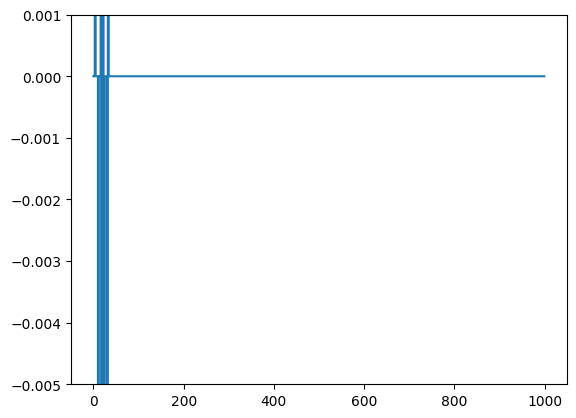

In [109]:
plt.plot(episodes_reward)
plt.ylim(-0.005,0.001)

In [118]:
def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int):
  state, info = env.reset()
  state = tf.constant(state, dtype=tf.float32)
  screen = env.render()
  images = [Image.fromarray(screen)]
  flatten = Flatten()

  for i in range(1, max_steps + 1):
    state=tf.expand_dims(state, axis=0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs[0][0]))
      
    state, reward, done, truncated, info = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render()
      images.append(Image.fromarray(screen))

    if done:
      break

  return images

In [128]:
from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("ALE/IceHockey-v5", render_mode="rgb_array")

# Save GIF image
images = render_episode(render_env, model, 500)
image_file = 'Icehockey-v5.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


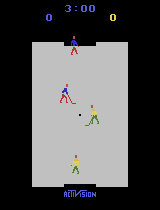

In [129]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)